In [116]:
from glob import glob
import numpy as np
import os
import argparse
import matplotlib.pyplot as plt
import seaborn as sns

import torchtext
import torch

from utils import tokenizer_with_preprocessing
from trainer import Trainer

LOG_DIR = os.path.join('.', 'logs')
NEWS_PATH = os.path.join('..', 'data', 'news')

In [107]:
parser = argparse.ArgumentParser()
parser.add_argument('--max_length', type=int, default=256)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--n_epochs', type=int, default=100)
parser.add_argument('--target_update_freq', type=int, default=100)
parser.add_argument('--evaluation_freq', type=int, default=10)
parser.add_argument('--network_save_freq', type=int, default=10)

parser.add_argument('--min_freq', type=int, default=10)
parser.add_argument('--embedding_dim', type=int, default=300)
parser.add_argument('--n_filters', type=int, default=100)
parser.add_argument('--filter_sizes', type=list, default=[3, 4, 5])
parser.add_argument('--pad_idx', type=list, default=1)
parser.add_argument('--gamma', type=float, default=0.97)
parser.add_argument('--learning_rate', type=float, default=2.5e-4)

parser.add_argument('--test', action='store_true')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
parser.add_argument('--device', type=str, default=device)

# QR-DQN
parser.add_argument('--num_quantile', type=int, default=51)

args = parser.parse_args(args=[])

torch.backends.cudnn.benchmark = True

# 読み込んだ内容に対して行う処理を定義
TEXT = torchtext.data.Field(sequential=True, tokenize=tokenizer_with_preprocessing,
                            use_vocab=True, lower=True, include_lengths=True,
                            batch_first=True, fix_length=args.max_length,
                            init_token="<cls>", eos_token="<eos>")
LABEL = torchtext.data.Field(sequential=False, use_vocab=False, dtype=torch.float)

train_ds = torchtext.data.TabularDataset.splits(
    path=NEWS_PATH, train='text_train.tsv',
    format='tsv',
    fields=[('Text1', TEXT), ('Text2', TEXT), ('Label', LABEL)])
train_ds = train_ds[0]

val_ds = torchtext.data.TabularDataset.splits(
    path=NEWS_PATH, train='text_val.tsv',
    format='tsv',
    fields=[('Text1', TEXT), ('Text2', TEXT), ('Label', LABEL)])
val_ds = val_ds[0]

TEXT.build_vocab(train_ds, min_freq=10)
TEXT.vocab.freqs

train_dl = torchtext.data.Iterator(
    train_ds, batch_size=1, train=True, shuffle=False)
val_dl = torchtext.data.Iterator(
    val_ds, batch_size=1, train=True, shuffle=False)

trainer = Trainer(args, TEXT, train_dl)
trainer.load_model()

#  シミュレーション

## 通常

In [203]:
dist_hist = []
reward_hist = []
epi_rewards = 0

for batch in val_dl:
    state = batch.Text1[0].to(trainer.device)
    reward = batch.Label.to(trainer.device)
    
    with torch.no_grad():
        dist = trainer.model(state) * trainer.quantile_weight
        dist_hist.append(dist.cpu().detach().numpy())
        reward_hist.append(reward.cpu().detach().numpy()[0])
        action = dist.sum(dim=2).max(1)[1]

    epi_rewards += (action * reward).detach().cpu().numpy().sum()

print(' '*20, 'train_reward: ', epi_rewards)
dist_hist = np.array(dist_hist).reshape(-1, 2, 51)

                     train_reward:  -7.700000379234552


## 期待値が正の場合のみ

In [211]:
dist_hist = []
reward_hist = []
epi_rewards = 0

for batch in val_dl:
    state = batch.Text1[0].to(trainer.device)
    reward = batch.Label.to(trainer.device)
    
    with torch.no_grad():
        dist = trainer.model(state) * trainer.quantile_weight
        dist_hist.append(dist.cpu().detach().numpy())
        reward_hist.append(reward.cpu().detach().numpy()[0])
        value = dist.sum(dim=2)[0][1]
        action = 0
        if value > 0:
            action = 1

    epi_rewards += (action * reward).detach().cpu().numpy().sum()

print(' '*20, 'train_reward: ', epi_rewards)
dist_hist = np.array(dist_hist).reshape(-1, 2, 51)

                     train_reward:  -14.137000445276499


## Sharpe Ratioが0.5以上のみ

In [255]:
dist_hist = []
reward_hist = []
action_hist = []
epi_rewards = 0

for batch in val_dl:
    state = batch.Text1[0].to(trainer.device)
    reward = batch.Label.to(trainer.device)
    
    with torch.no_grad():
        dist = trainer.model(state) * trainer.quantile_weight
        dist_hist.append(dist.cpu().detach().numpy())
        reward_hist.append(reward.cpu().detach().numpy()[0])
        dist = dist[0][1].cpu().detach().numpy()
        sr = dist.mean() / dist.std()
        action = 0
        if sr > 0.3:
            action = 1
            
        action_hist.append(action)
        

    epi_rewards += (action * reward).detach().cpu().numpy().sum()

print(' '*20, 'train_reward: ', epi_rewards)
dist_hist = np.array(dist_hist).reshape(-1, 2, 51)
action_hist = np.array(action_hist)

                     train_reward:  19.09599982202053


In [257]:
len(action_hist)

207

# プロット

i =  0 ポジション: 1 実際: -1.979 平均: 0.001 Sharpe Ratio: 0.076
i =  1 ポジション: 1 実際: -2.612 平均: 0.002 Sharpe Ratio: 0.137
i =  2 ポジション: 0 実際: -0.493 平均: -0.002 Sharpe Ratio: -0.205
i =  3 ポジション: 1 実際: -1.588 平均: 0.005 Sharpe Ratio: 0.409
i =  4 ポジション: 0 実際: 2.931 平均: -0.001 Sharpe Ratio: -0.072
i =  5 ポジション: 0 実際: -2.244 平均: -0.003 Sharpe Ratio: -0.256
i =  6 ポジション: 1 実際: -0.252 平均: 0.01 Sharpe Ratio: 0.839
i =  7 ポジション: 0 実際: 0.92 平均: -0.008 Sharpe Ratio: -0.68
i =  8 ポジション: 1 実際: -3.38 平均: 0.0 Sharpe Ratio: 0.026
i =  9 ポジション: 0 実際: 6.727 平均: -0.008 Sharpe Ratio: -0.608


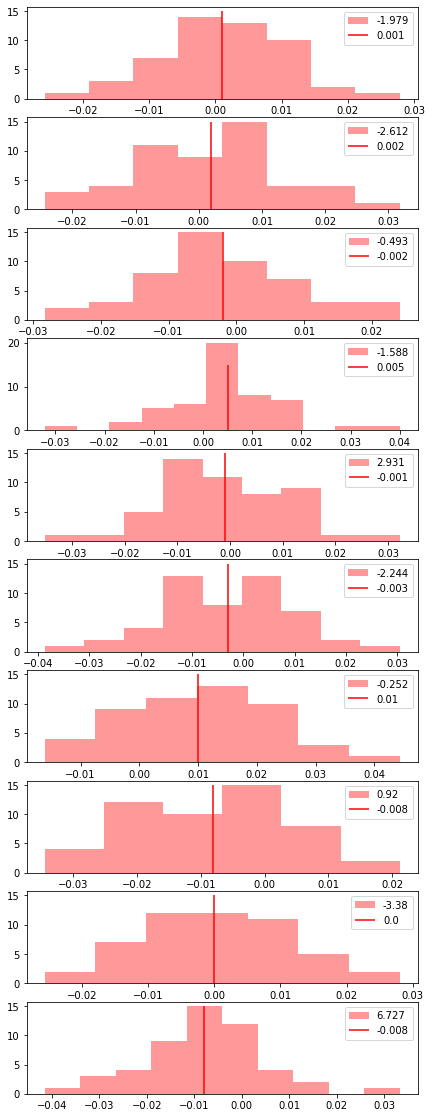

In [194]:
start = 0
N = 10
fig, ax = plt.subplots((N-start), 1, figsize=(7, (N-start)*2));
for i in range(start, N):    
    # 分布
    sns.distplot(dist_hist[i][1], color='red', kde=False, ax=ax[i - start], label=str(reward_hist[i]))
    
    dist = dist_hist[i][1]
    
    # 期待値
    mean = np.round(dist.mean(), 3)
    ax[i - start].vlines(mean, ymin=0, ymax=15, color='red', label=str(mean))
    
    # sharpe ratio
    sr = np.round(dist.mean() / dist.std(), 3)

    print('i = ', i,
              'ポジション:', dist_hist[i].mean(axis=1).argmax(), 
              '実際:', reward_hist[i],
              '平均:', mean,
              'Sharpe Ratio:', sr)
    
    ax[i-start].legend()

In [187]:
dist

array([-0.0282858 , -0.01642321, -0.02452788, -0.019305  , -0.01693838,
       -0.01271637, -0.00363959, -0.01387536, -0.0117728 , -0.00621498,
       -0.00959486, -0.01483895, -0.01271941, -0.00504461, -0.00431559,
       -0.00299897, -0.00588884, -0.00324144, -0.00122971, -0.00735919,
       -0.00591233, -0.0119299 ,  0.00123414, -0.00484257, -0.00338958,
       -0.00024252,  0.00357215, -0.0090677 ,  0.00371688, -0.00604183,
        0.00115747,  0.00506036, -0.00328938,  0.01180768,  0.01123195,
        0.00056515,  0.00745499, -0.00358101,  0.00662213, -0.00262956,
        0.00126195, -0.0018238 ,  0.00696386,  0.00572215, -0.00112487,
        0.0055502 ,  0.01008404,  0.01940123,  0.01711908,  0.01977964,
        0.02412279], dtype=float32)

#  actionを色々変える

tensor([[-0.0401,  0.3743]], device='cuda:0')